Тетрадка для предобработки данных.

# Import

In [2]:
import os
from dotenv import load_dotenv
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import category_encoders as ce

import torch
from torch.utils.data import Dataset


load_dotenv()
sklearn.set_config(transform_output="pandas")

# Config

In [2]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

Реализация класса для работы с данными ([документация](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)).

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset_path: str, label_name: str, transform: Pipeline = None, target_transform: Pipeline = None):
        dataset = pd.read_csv(dataset_path)
        self.X, self.y = dataset.drop(label_name, axis=1), dataset[label_name]
        self.transform = transform
        self.target_transform = target_transform

        if self.transform:
            self.X = self.transform.fit_transform(self.X)
        
        if self.target_transform:
            self.y = self.target_transform.fit_transform(self.y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X.iloc[idx], self.y.iloc[idx]
    
    def _preprocess(self):
        pass

Вспомогательные функции.

In [3]:
def hour_to_weekday(hour):
    day = hour // 24
    weekday = day % 7
    return weekday


def hour_to_hour(hour):
    return hour % 24

# Load data

In [161]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [162]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

In [4]:
# Промежуточные данные
ext_user_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_users.csv"))
ext_history_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_history.csv"))
ext_validate_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate.csv"))

ext_validate_answers_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_answers.csv"))

# Data cleaning and preparation

___
**users.tsv:**
- все пользователи уникальные,
- 30 пользователей без пола, примерно 50/50,
- 2180 пропущено возрастов, есть люди страше 90 лет,
- 84790 пропущено городов, город с id=3 концентрирует в себе пользователей.

**history.tsv:**
- два выброса по cpm,
- есть периодичность по времени,
- все просмотры сконцентрированы на 4 площадках,
- два пользователя смотрят очень много объявлений (мб выбросы и стоит обрезать).

**validate.tsv:**
- максимум используется 6 площадок, в основном 3-4.

### Users

In [290]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [291]:
round((user_ds[["sex", "age", "city_id"]] == 0).sum()/len(user_ds), 3)

sex        0.001
age        0.079
city_id    0.305
dtype: float64

### History

In [222]:
history_ds.isnull().sum()

hour         0
cpm          0
publisher    0
user_id      0
dtype: int64

In [223]:
history_ds["hour"].min(), history_ds["cpm"].min(), history_ds["publisher"].min()

(np.int64(3), np.float64(30.0), np.int64(1))

In [ ]:
history_ds = history_ds.rename(columns={"hour": "hour_old"})

In [165]:
# Перевод часов в дни недели и в интервал [0-23]
history_ds["weekday"] = history_ds["hour_old"].apply(hour_to_weekday)
history_ds["hour"] = history_ds["hour_old"].apply(hour_to_hour)

In [166]:
history_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_history.csv"), index=False)

### Validate

In [167]:
validate_ds.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [241]:
validate_ds.dtypes

cpm              float64
hour_start         int64
hour_end           int64
publishers        object
audience_size      int64
user_ids          object
dtype: object

In [168]:
validate_ds["publishers"] = validate_ds["publishers"].apply(lambda publishers: [int(publisher) for publisher in publishers.split(",")])
validate_ds["user_ids"] = validate_ds["user_ids"].apply(lambda user_ids: [int(user_id) for user_id in user_ids.split(",")])

In [245]:
# Есть ли пропуски
min([len(publishers) for publishers in validate_ds["publishers"]]), min(validate_ds["audience_size"])

(1, 300)

In [169]:
validate_ds = validate_ds.rename(columns={"hour_start": "hour_start_old"})

In [170]:
# Переводим hour_start в день недели и суточный час, hour_end убираем и вместо него указываем длительность
validate_ds["weekday_start"] = validate_ds["hour_start_old"].apply(hour_to_weekday)
validate_ds["duration"] = validate_ds["hour_end"] - validate_ds["hour_start_old"]
validate_ds["hour_start"] = validate_ds["hour_start_old"].apply(hour_to_weekday)

In [171]:
# Создаем новый признак на основе publishers
validate_ds["publisher_quantity"] = validate_ds["publishers"].apply(lambda publishers: len(publishers))

In [172]:
validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4


In [173]:
validate_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate.csv"), index=False)

### Validate_answers

In [14]:
validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


In [39]:
# Переводим в количество просмотров
for i, row in validate_answers_ds.iterrows():
    audience_size = validate_ds.loc[i, "audience_size"]

    validate_answers_ds.loc[i, "at_least_one"] = round(audience_size*validate_answers_ds.loc[i, "at_least_one"])
    validate_answers_ds.loc[i, "at_least_two"] = round(audience_size*validate_answers_ds.loc[i, "at_least_two"])
    validate_answers_ds.loc[i, "at_least_three"] = round(audience_size*validate_answers_ds.loc[i, "at_least_three"])

validate_answers_ds = validate_answers_ds.apply(np.int64)

In [13]:
validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,82,29,14
1,18,0,0
2,78,12,0
3,101,57,32
4,585,411,335


In [14]:
validate_answers_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_answers.csv"), index=False)

# EDA

### Users

In [17]:
user_ds.head()

,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4


<Axes: xlabel='sex'>

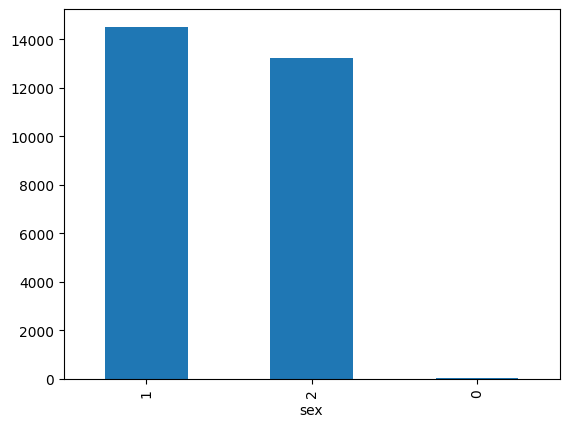

In [21]:
user_ds["sex"].value_counts().plot(kind="bar")

In [40]:
# Присваиваем всех нулевым значение 1
user_ds["sex"] = user_ds["sex"].replace(0, 1)
user_ds["sex"] = user_ds["sex"] - 1

In [41]:
# Создадим дополнительную таблицу для лучшего понимания распределения
add_user_ds = user_ds.copy()

add_data = {
    "publishers": [],
    "publisher_quantity": [],
    "hours": [],
    "weekdays": [],
    "views": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    user_id = row["user_id"]

    add_data["publishers"].append(np.unique(history_ds[history_ds["user_id"] == user_id]["publisher"]))
    add_data["publisher_quantity"].append(len(add_data["publishers"][i]))
    add_data["hours"].append(list(history_ds[history_ds["user_id"] == user_id]["hour"]))
    add_data["weekdays"].append(list(history_ds[history_ds["user_id"] == user_id]["weekday"]))
    add_data["views"].append(len(add_data["hours"][i]))

add_user_ds = add_user_ds.assign(**add_data)

100%|██████████| 27769/27769 [00:58<00:00, 473.02it/s]


<Axes: >

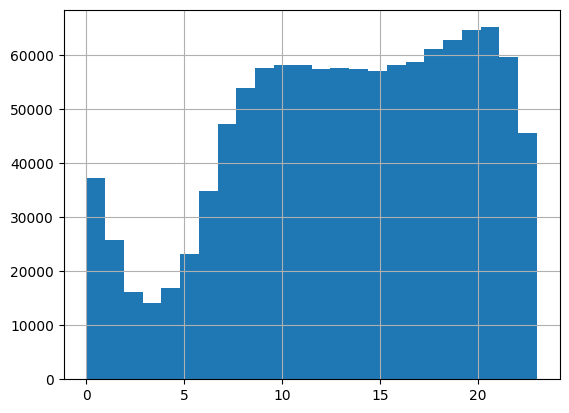

In [ ]:
# В какое время чаще всего засиживаются и в какой день недели
history_ds["hour"].hist(bins=24)

<Axes: >

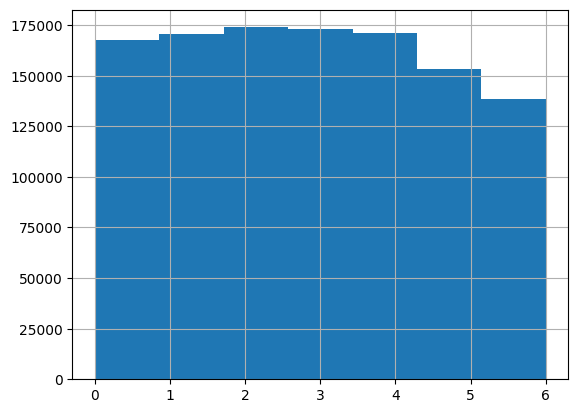

In [15]:
history_ds["weekday"].hist(bins=7)

По графикам выше видно что чаще всего заходят с 17 до 21, меньше всего с 22 до 6. В выходные тоже заходят меньше всего.

In [42]:
# Добавим категориальные признаки top_hour: ["22-7", "8-15", "16-21"], top_hour_ratio: float и is_weekend: float
new_data = {
    "top_time_interval": [],
    "top_time_interval_ratio": [],
    "is_workday": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["views"] == 0:
        new_data["top_time_interval"].append(None)
        new_data["top_time_interval_ratio"].append(None)
        new_data["is_workday"].append(None)
        continue

    hours, counts = np.unique(row["hours"], return_counts=True)
    intervals = {
        "22-7": (hours <= 7) | (hours >= 22),
        "8-15": (hours >= 8) & (hours <= 15),
        "16-21": (hours >= 16) & (hours <= 21),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_time_interval = max(interval_counts, key=interval_counts.get)
    top_time_interval_ratio = interval_counts[top_time_interval]/np.sum(list(interval_counts.values()))

    weekdays, counts = np.unique(row["weekdays"], return_counts=True)
    intervals = {
        "0-4": (weekdays <= 4),
        "5-6": (weekdays >= 5)
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    is_workday = interval_counts["0-4"]/np.sum(list(interval_counts.values()))
    
    new_data["top_time_interval"].append(top_time_interval)
    new_data["top_time_interval_ratio"].append(top_time_interval_ratio)
    new_data["is_workday"].append(is_workday)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:03<00:00, 8077.44it/s]


<Axes: xlabel='publisher'>

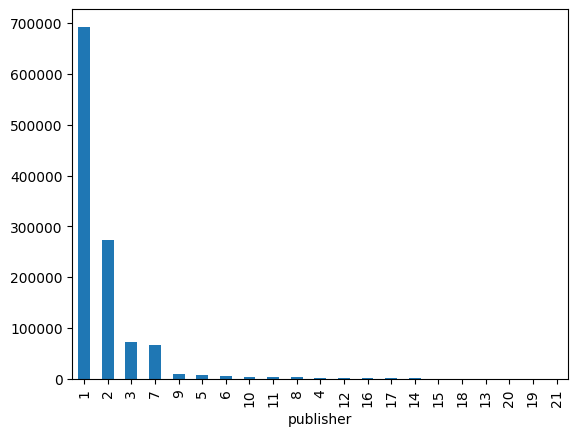

In [62]:
# Популярность площадок
history_ds["publisher"].value_counts().plot(kind="bar")

In [43]:
# Добавим категориальные признаки
# Есть ли популярная площадка top_publisher_type: ["well_done", "medium", "rare"]
# Доля популярной площадки top_publisher_type_ratio: float
new_data = {
    "top_publisher": [],
    "top_publisher_ratio": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["publisher_quantity"] == 0:
        new_data["top_publisher"].append(None)
        new_data["top_publisher_ratio"].append(None)
        continue

    publishers, counts = np.unique(row["publishers"], return_counts=True)
    intervals = {
        "well_done": (publishers <= 2),
        "medium": (publishers == 3) | (publishers == 7),
        "rare": (publishers == 4) | (publishers == 5) | (publishers == 6) | (publishers >= 8),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_publisher = max(interval_counts, key=interval_counts.get)
    top_publisher_ratio = interval_counts[top_publisher]/np.sum(list(interval_counts.values()))

    new_data["top_publisher"].append(top_publisher)
    new_data["top_publisher_ratio"].append(top_publisher_ratio)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:02<00:00, 11881.99it/s]


In [44]:
# Удаляем ненужные признаки
add_user_ds = add_user_ds.drop(columns=["publishers", "hours", "weekdays"])

In [16]:
add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,0,1,2,8-15,0.500000,1.000000,well_done,1.0
1,1,0,0,1,1,82,8-15,0.585366,0.597561,well_done,1.0
2,2,1,24,2,0,0,None,NaN,NaN,None,NaN
3,3,0,20,3,2,8,8-15,0.500000,0.750000,well_done,0.5
4,4,1,29,4,2,132,8-15,0.560606,0.848485,well_done,0.5


In [61]:
round(add_user_ds.isna().sum()/len(add_user_ds)*100, 2)

user_id                    0.00
sex                        0.00
age                        0.00
city_id                    0.00
publisher_quantity         0.00
views                      0.00
top_time_interval          8.04
top_time_interval_ratio    8.04
is_workday                 8.04
top_publisher              8.04
top_publisher_ratio        8.04
dtype: float64

<BarContainer object of 2457 artists>

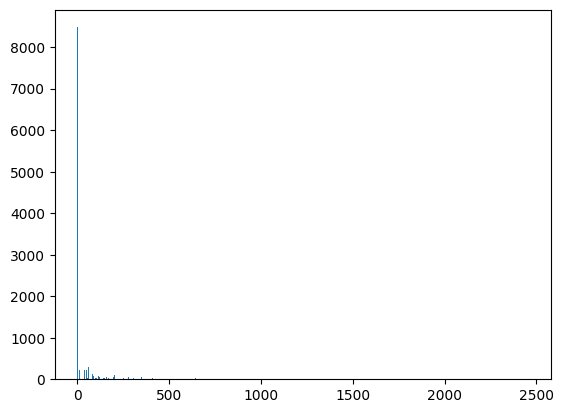

In [96]:
# Популярность городов
city_ids, counts = np.unique(add_user_ds["city_id"], return_counts=True)
plt.bar(city_ids, counts)

In [20]:
round((add_user_ds["city_id"] == 0).sum()/len(add_user_ds)*100, 2)

np.float64(30.53)

In [68]:
с_add_user_ds = add_user_ds.copy()

In [69]:
# Меняем категориальные признаки
encoder = ce.CountEncoder(cols=["city_id"])
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,8-15,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,8-15,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,None,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,8-15,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,8-15,0.560606,0.848485,well_done,0.5


In [70]:
encoder = ce.OneHotEncoder(cols=["top_time_interval"], use_cat_names=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,well_done,0.5


In [71]:
mapping = [{'col': 'top_publisher', 'mapping': {"well_done": 3, "medium": 2, "rare": 1}}]
encoder = ce.OrdinalEncoder(mapping=mapping, cols=["top_publisher"], drop_invariant=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,3.0,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,3.0,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,3.0,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,3.0,0.5


In [72]:
# Переводим в int
с_add_user_ds = с_add_user_ds.replace({'top_publisher': -1}, np.nan)
с_add_user_ds = с_add_user_ds.astype({"top_time_interval_8-15": "Int64", "top_time_interval_16-21": "Int64", "top_time_interval_22-7": "Int64", "top_publisher": "Int64"})
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
2,2,1,24,1,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5


<Axes: >

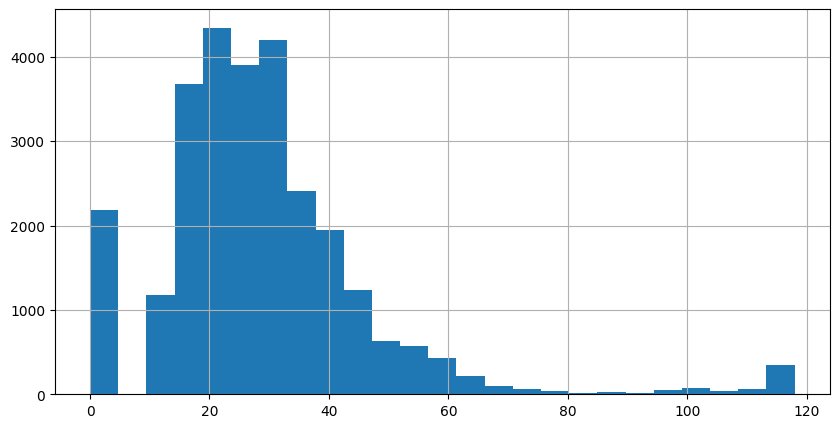

In [152]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [73]:
# Убираем выбросы: кто старше 90 тому присваиваем mean
mask = ((с_add_user_ds["age"] != 0) & (с_add_user_ds["age"] < 90))
mean_age = np.mean(с_add_user_ds.loc[mask, "age"]).astype(np.int64)

mask = с_add_user_ds["age"] >= 90
с_add_user_ds.loc[mask, "age"] = mean_age

<Axes: >

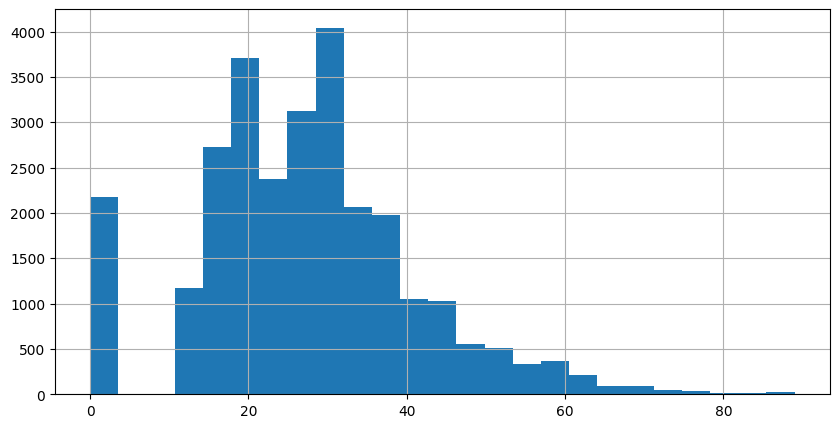

In [154]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [74]:
# Возьмем юзеров без пропущенных значений
c_add_user_ds_subset = с_add_user_ds[с_add_user_ds["views"] != 0]
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


<Axes: >

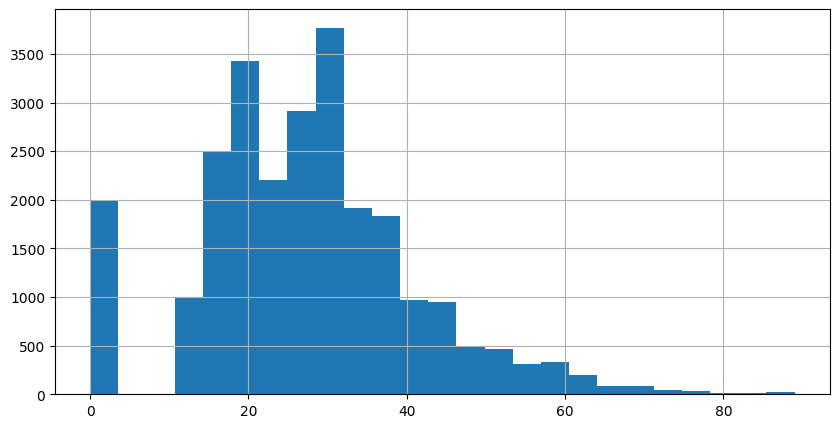

In [156]:
c_add_user_ds_subset["age"].hist(bins=25, figsize=(10, 5))

In [75]:
# Присвоим None к возрасту и заполним их
c_add_user_ds_subset = c_add_user_ds_subset.replace({"age": 0}, np.nan)

imputer = KNNImputer(n_neighbors=5, weights="uniform")
c_add_user_ds_subset["age"] = imputer.fit_transform(c_add_user_ds_subset.drop(columns=["user_id"]))["age"].astype(np.int64)
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,30,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


<Axes: >

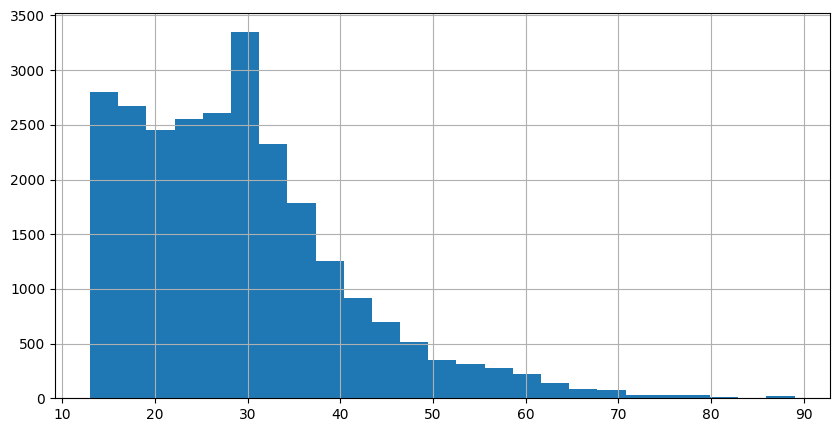

In [76]:
c_add_user_ds_subset["age"].hist(bins=25, figsize=(10, 5))

In [24]:
# Вносим в наш датасет найденные значения
mask = с_add_user_ds['user_id'].isin(c_add_user_ds_subset['user_id'])
с_add_user_ds.loc[mask, "age"] = c_add_user_ds_subset["age"]

<Axes: >

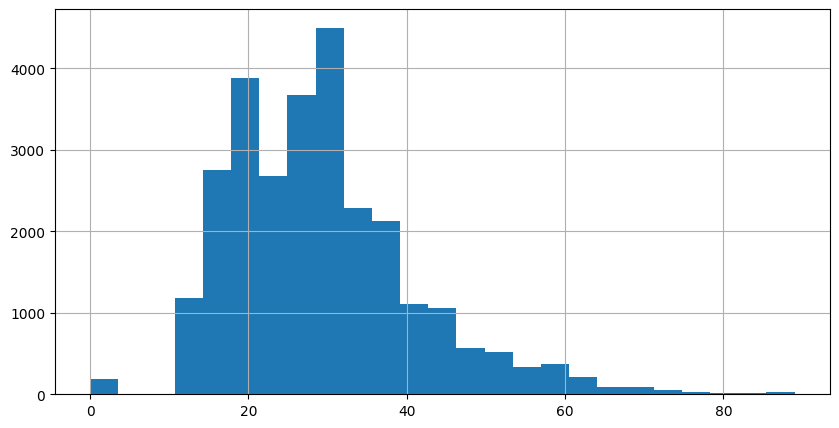

In [25]:
с_add_user_ds["age"].hist(bins=25, figsize=(10, 5))

In [164]:
с_add_user_ds[с_add_user_ds["age"] == 0].head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
10,10,0,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
143,143,1,0,237,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
317,317,1,0,8479,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
351,351,0,0,308,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
359,359,1,0,237,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN


In [26]:
round(с_add_user_ds["age"].describe(), 2)

count    27769.00
mean        29.18
std         11.81
min          0.00
25%         20.00
50%         28.00
75%         35.00
max         89.00
Name: age, dtype: float64

In [31]:
с_add_user_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_users.csv"), index=False)

### Validate

In [10]:
ext_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,3.0,1.0
1,1,0,30,16,1,82,1.0,0.0,0.0,0.585366,0.597561,3.0,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,3.0,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,3.0,0.5


In [11]:
ext_history_ds.head()

,hour_old,cpm,publisher,user_id,weekday,hour
0,10,30.00,1,15661,0,10
1,8,41.26,1,8444,0,8
2,7,360.00,1,15821,0,7
3,18,370.00,1,21530,0,18
4,8,195.00,2,22148,0,8


<BarContainer object of 297 artists>

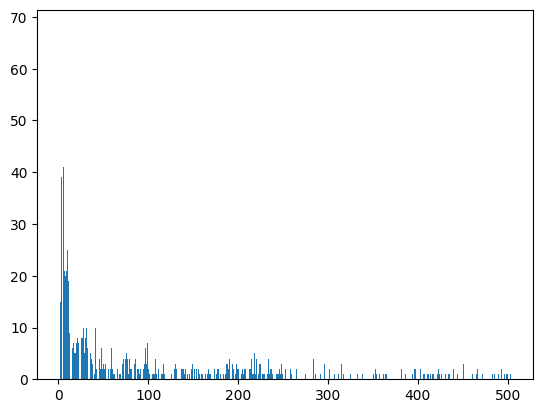

In [9]:
v, c = np.unique(ext_validate_ds["duration"], return_counts=True)
plt.bar(v, c)

___
**Новые признаки:**
- Доля мужчин (**сомнительный**),
- Средний возраст пользователей,
- Мода города среди пользователей, отношение (**сомнительный**),
- Среднее количество площадок у пользователей, мода популярной площадки среди пользователей, отношение (?),
- Среднее количество просмотров каждого пользователя на данных площадках в заданный промежуток времени,
- Популярный промежуток времени просмотра рекламы пользователей для данных площадок,
- В будни или в выходные пользователи смотрят рекламу,
- Средняя продолжительность сессии у пользователей на площадках в заданный промежуток времени,
- Средняя цена объявлений на данных площадках в заданный промежуток времени.

**Убрать признаки:**
- user_ids,
- hour_end.

**Преобразование признаков:**
- publishers в количество площадок.

In [175]:
ext_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,3.0,1.0
1,1,0,30,16,1,82,1.0,0.0,0.0,0.585366,0.597561,3.0,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,3.0,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,3.0,0.5


In [176]:
ext_history_ds.head()

,hour_old,cpm,publisher,user_id,weekday,hour
0,10,30.00,1,15661,0,10
1,8,41.26,1,8444,0,8
2,7,360.00,1,15821,0,7
3,18,370.00,1,21530,0,18
4,8,195.00,2,22148,0,8


In [177]:
ext_validate_ds["publishers"] = ext_validate_ds["publishers"].apply(ast.literal_eval)
ext_validate_ds["user_ids"] = ext_validate_ds["user_ids"].apply(ast.literal_eval)
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4


In [178]:
# Доля мужчин
ext_validate_ds["sex_ration"] = ext_validate_ds["user_ids"].apply(lambda user_ids:  ext_user_ds[ext_user_ds["user_id"].isin(user_ids)]["sex"].sum()/len(user_ids))
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,sex_ration
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.462225
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.467391
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.467342
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.454545
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.387534


In [179]:
# Средний возраст пользователей
ext_validate_ds["age_mean"] = ext_validate_ds["user_ids"].apply(lambda user_ids: np.mean(ext_user_ds[ext_user_ds["user_id"].isin(user_ids)]["age"]).astype(np.int64))
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,sex_ration,age_mean
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.462225,29
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.467391,28
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.467342,29
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.454545,28
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.387534,44


In [180]:
# Мода города среди пользователей, отношение
new_data = {
    "city_mode": [],
    "city_mode_ratio": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    mask = ext_user_ds["user_id"].isin(row["user_ids"])
    mode, count = stats.mode(ext_user_ds.loc[mask, "city_id"])
    
    new_data["city_mode"].append(mode)
    new_data["city_mode_ratio"].append(count/len(row["user_ids"]))

ext_validate_ds = ext_validate_ds.assign(**new_data)
ext_validate_ds.head()

100%|██████████| 1008/1008 [00:00<00:00, 1160.23it/s]


,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,sex_ration,age_mean,city_mode,city_mode_ratio
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.462225,29,315,0.165268
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.467391,28,8479,0.237681
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.467342,29,8479,0.284910
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.454545,28,308,0.156818
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.387534,44,8479,0.274390


In [ ]:
# Мода популярной площадки среди пользователей, отношение
# ext_validate_ds["user_publisher_quantity_max"] = ext_validate_ds["user_ids"].apply(lambda user_ids: np.mean(ext_user_ds[ext_user_ds["user_id"].isin(user_ids)]["publisher_quantity"]).astype(np.int64))

# new_data = {
#     "city_mode": [],
#     "city_mode_ratio": []
# }
# for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
#     mask = ext_user_ds["user_id"].isin(row["user_ids"])
#     mode, count = stats.mode(ext_user_ds.loc[mask, "city_id"])
    
#     new_data["city_mode"].append(mode)
#     new_data["city_mode_ratio"].append(count/len(row["user_ids"]))

# ext_validate_ds = ext_validate_ds.assign(**new_data)
# ext_validate_ds.head()

In [216]:
# Среднее количество просмотров каждого пользователя на данных площадках в заданный промежуток времени
new_data = {
    "users_views_on_pubs_mean": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    mask = (ext_history_ds["user_id"].isin(row["user_ids"])) & (ext_history_ds["publisher"].isin(row["publishers"])) & (ext_history_ds["hour_old"].between(row["hour_start_old"], row["hour_end"], "both"))
    if len(ext_history_ds.loc[mask, "user_id"]) == 0:
        new_data["users_views_on_pubs_mean"].append(0)
        continue

    user_ids, counts = np.unique(ext_history_ds.loc[mask, "user_id"], return_counts=True)
    new_data["users_views_on_pubs_mean"].append(round(np.mean(counts)))

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:21<00:00, 46.29it/s]


In [233]:
# Популярный промежуток времени просмотра рекламы пользователей для данных площадок, отношение
# В будни или в выходные пользователи смотрят рекламу на данных площадках
new_data = {
    "time_interval_mode": [],
    "time_interval_ratio": [],
    "is_workday": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    mask = (ext_history_ds["user_id"].isin(row["user_ids"])) & (ext_history_ds["publisher"].isin(row["publishers"]))
    if len(ext_history_ds.loc[mask, "hour"]) == 0:
        new_data["time_interval_mode"].append(np.nan)
        new_data["time_interval_ratio"].append(np.nan)
        new_data["is_workday"].append(np.nan)
        continue

    hours, counts = np.unique(ext_history_ds.loc[mask, "hour"], return_counts=True)
    intervals = {
        "22-7": (hours <= 7) | (hours >= 22),
        "8-15": (hours >= 8) & (hours <= 15),
        "16-21": (hours >= 16) & (hours <= 21),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    time_interval_mode = max(interval_counts, key=interval_counts.get)
    time_interval_ratio = interval_counts[time_interval_mode]/np.sum(list(interval_counts.values()))

    weekdays, counts = np.unique(ext_history_ds.loc[mask, "weekday"], return_counts=True)
    intervals = {
        "0-4": (weekdays <= 4),
        "5-6": (weekdays >= 5)
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    is_workday = interval_counts["0-4"]/np.sum(list(interval_counts.values()))

    new_data["time_interval_mode"].append(time_interval_mode)
    new_data["time_interval_ratio"].append(time_interval_ratio)
    new_data["is_workday"].append(is_workday)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:21<00:00, 47.27it/s]


In [234]:
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,sex_ration,age_mean,city_mode,city_mode_ratio,users_views_on_pubs_mean,time_interval_mode,time_interval_ratio,is_workday
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.462225,29,315,0.165268,3,8-15,0.468247,0.801000
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.467391,28,8479,0.237681,3,8-15,0.364001,0.744324
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.467342,29,8479,0.284910,2,8-15,0.405235,0.744141
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.454545,28,308,0.156818,4,8-15,0.414252,0.742263
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.387534,44,8479,0.274390,9,8-15,0.376445,0.744949


In [ ]:
# Средняя продолжительность сессии у пользователей на площадках в заданный промежуток времени


In [ ]:
# Средняя цена объявлений на данных площадках в заданный промежуток времени


# Preprocess

In [ ]:
# Define the data path and taget
dataset_path = os.path.join(INPUT_DATA_PATH, "name_of_file.csv")
label_name = "label_name"
# Define the transformers
feature_transform = Pipeline([
    ("normalizer", Normalizer()),
    ("scaler", StandardScaler())
])
target_transform = Pipeline([
    ("label_encoder", LabelEncoder())
])
# Create the dataset
train_dataset = CustomImageDataset(
    dataset_path=dataset_path,
    label_name=label_name,
    transform=feature_transform,
    target_transform=target_transform
)